In [22]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

数据处理（包括相关性分析与PCA分析）

In [23]:
def load_and_analyze_data(test_size=0.1, random_state=42, use_pca=False, n_components=None):
    data = pd.read_excel("BostonHousingData.xlsx")
    # 相关性分析
    plt.figure(figsize=(12, 10))
    corr_matrix = data.corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')#热力图
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    # 数据处理
    x_data = data.iloc[:, :13].values
    y_data = data.MEDV.values.reshape(-1, 1)
    feature_names = data.columns[:13]
    scaler = StandardScaler()
    x_data = scaler.fit_transform(x_data)
    
    # 3. PCA分析与可视化
    if use_pca:
        pca = PCA(n_components=n_components)
        x_pca = pca.fit_transform(x_data)
        
        print("\n=== 主成分特征权重 ===")
        components_df = pd.DataFrame(
            pca.components_,
            columns=feature_names,
            index=[f'PC{i+1}' for i in range(pca.n_components_)]
        )
        print(components_df.round(3))
        
        print("\n=== 各主成分主要特征 ===")
        for i in range(pca.n_components_):
            print(f"\nPC{i+1}（解释方差：{pca.explained_variance_ratio_[i]:.2%}）")
            top_features = components_df.iloc[i].abs().nlargest(3)
            print(top_features.to_string(float_format="%.3f"))
        
        # 解释方差比例（成分占比）
        plt.figure(figsize=(10, 6))
        plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
        plt.xlabel('Principal Component')
        plt.ylabel('Variance Explained')
        plt.title('PCA Explained Variance Ratio')
        plt.show()
        
        # 累计解释方差
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Cumulative Explained Variance')
        plt.grid(True)
        plt.show()
        
        # 主成分散点图
        if n_components >= 2:
            plt.figure(figsize=(10, 6))
            plt.scatter(x_pca[:, 0], x_pca[:, 1], c=data['MEDV'], cmap='viridis')
            plt.colorbar(label='MEDV')
            plt.xlabel('First Principal Component')
            plt.ylabel('Second Principal Component')
            plt.title('PCA Components Colored by MEDV')
            plt.show()

        # 使用PCA转换后的数据
        x_data = x_pca
    
    # 划分数据集
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=test_size, random_state=random_state
    )
    
    # 转换为PyTorch张量
    xt_train = torch.FloatTensor(x_train)
    xt_test = torch.FloatTensor(x_test)
    yt_train = torch.FloatTensor(y_train)
    yt_test = torch.FloatTensor(y_test)
    
    return (xt_train, yt_train), (xt_test, yt_test), scaler, feature_names


数据加载

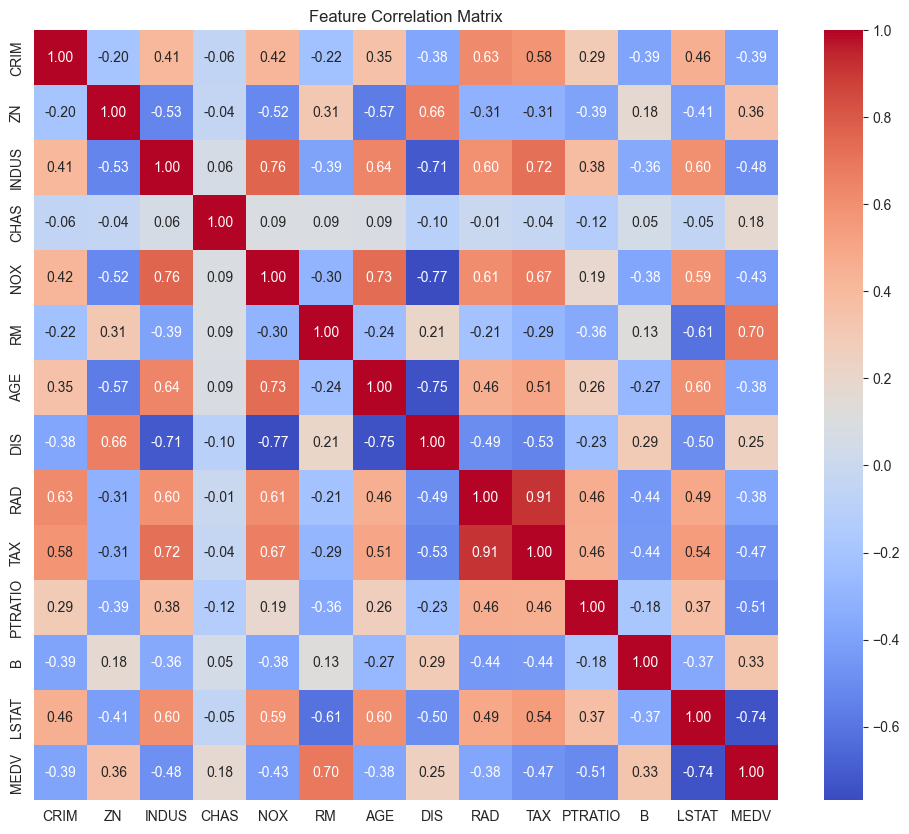


=== 主成分特征权重 ===
       CRIM     ZN  INDUS   CHAS    NOX     RM    AGE    DIS    RAD    TAX  \
PC1   0.251 -0.256  0.347  0.005  0.343 -0.189  0.314 -0.322  0.320  0.338   
PC2  -0.315 -0.323  0.112  0.455  0.219  0.149  0.312 -0.349 -0.272 -0.239   
PC3   0.247  0.296 -0.016  0.290  0.121  0.594 -0.018 -0.050  0.287  0.221   
PC4   0.062  0.129  0.017  0.816 -0.128 -0.281 -0.175  0.215  0.132  0.103   
PC5  -0.082 -0.321  0.008 -0.087 -0.137  0.423 -0.017 -0.099  0.204  0.130   
PC6   0.220  0.323  0.076 -0.167  0.153 -0.059  0.072 -0.023  0.143  0.193   
PC7   0.778 -0.275 -0.340  0.074 -0.200  0.064  0.116 -0.104 -0.138 -0.315   
PC8  -0.153  0.403 -0.174  0.025 -0.080  0.327  0.601  0.122 -0.080 -0.083   
PC9   0.260  0.358  0.644 -0.014 -0.019  0.048 -0.068 -0.153 -0.471 -0.177   
PC10 -0.019 -0.268  0.364  0.006 -0.231  0.431 -0.363  0.171 -0.022  0.035   
PC11  0.110 -0.263  0.303 -0.014 -0.111 -0.053  0.459  0.696 -0.037  0.105   
PC12  0.087 -0.071 -0.113 -0.004  0.804  0.153 

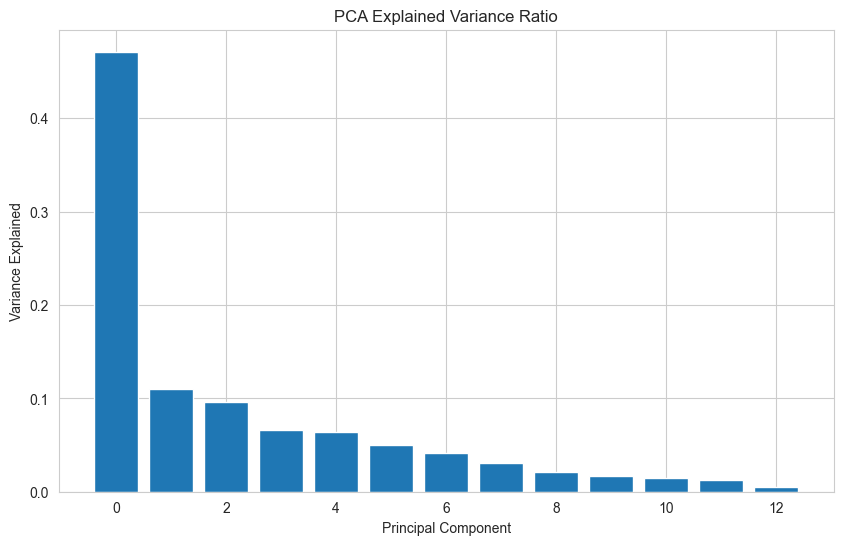

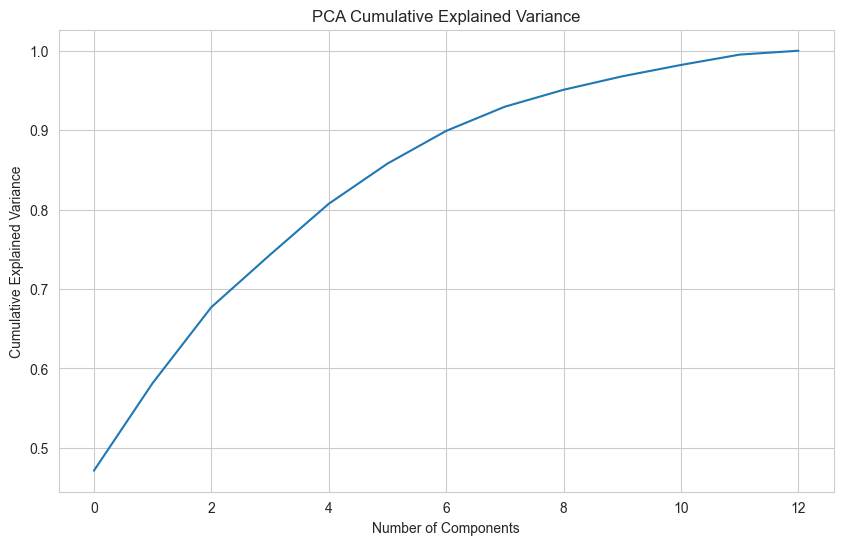

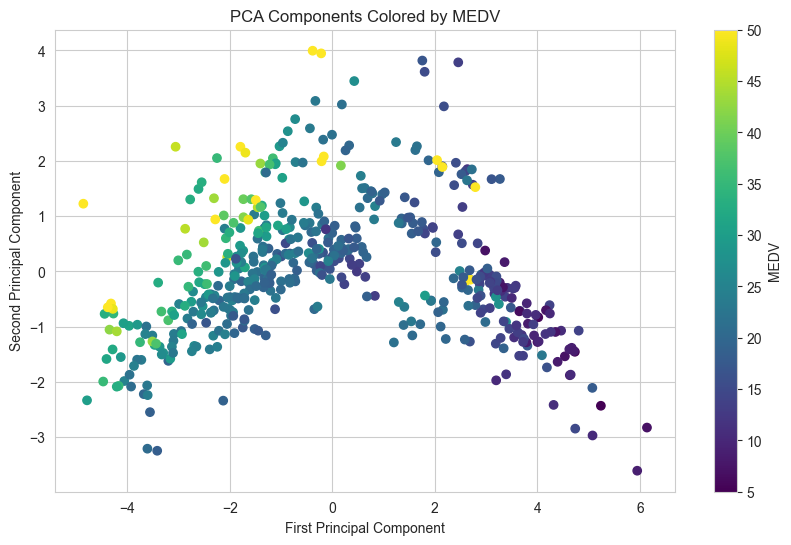

In [24]:
(xt_train, yt_train), (xt_test, yt_test), scaler, feature_names = load_and_analyze_data(use_pca=True, n_components=13)

train_dataset = Data.TensorDataset(xt_train, yt_train)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True )  

模型定义（三层全连接网络）

In [25]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.05),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)

#模型初始化
model = Model(input_dim=xt_train.shape[1]) 
print(model)

Model(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


模型结构

训练函数

In [26]:
def train_model(model, train_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.0005, weight_decay= 0.0001)
    criterion = nn.MSELoss()#适用于回归问题
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.9)
    
    model.train()
    loss_history = []  
    
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss)
        
        if epoch % 15 == 0:
            print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")
    return model, loss_history

评估函数

In [27]:
def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).numpy()
        y_test = y_test.numpy()
        
        # 计算评估指标
        mse = mean_squared_error(y_test, predictions)#
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)#
        r2 = r2_score(y_test, predictions)#
        
        # 打印评估结果
        print("\n" + "—"*50)
        print("Model Evaluation Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R² Score: {r2:.4f}")
        print("—"*50 + "\n")
        
        # 绘制预测结果
        plt.figure(figsize=(12, 6))
        
        # 实际vs预测散点图
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, predictions, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.title('Actual vs Predicted Prices')
        plt.grid(True)
        
        # 残差图
        plt.subplot(1, 2, 2)
        residuals = y_test - predictions
        plt.scatter(predictions, residuals, alpha=0.6)
        plt.hlines(0, predictions.min(), predictions.max(), colors='k', linestyles='dashed')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Analysis')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}


训练模型

Epoch 0: Loss = 596.2858, LR = 0.000500
Epoch 15: Loss = 66.6634, LR = 0.000500
Epoch 30: Loss = 12.2042, LR = 0.000500
Epoch 45: Loss = 10.6894, LR = 0.000450
Epoch 60: Loss = 11.3195, LR = 0.000405
Epoch 75: Loss = 8.4884, LR = 0.000328
Epoch 90: Loss = 7.7508, LR = 0.000295
Epoch 105: Loss = 8.8794, LR = 0.000239
Epoch 120: Loss = 6.9895, LR = 0.000194
Epoch 135: Loss = 7.1843, LR = 0.000141
Epoch 150: Loss = 7.1641, LR = 0.000114
Epoch 165: Loss = 7.4659, LR = 0.000083
Epoch 180: Loss = 7.7855, LR = 0.000075
Epoch 195: Loss = 6.4389, LR = 0.000055
Epoch 210: Loss = 8.6973, LR = 0.000044
Epoch 225: Loss = 5.2955, LR = 0.000032
Epoch 240: Loss = 6.2772, LR = 0.000026
Epoch 255: Loss = 5.7063, LR = 0.000019
Epoch 270: Loss = 7.1483, LR = 0.000015
Epoch 285: Loss = 5.4572, LR = 0.000011
Epoch 300: Loss = 5.2493, LR = 0.000009
Epoch 315: Loss = 6.5859, LR = 0.000007
Epoch 330: Loss = 7.4585, LR = 0.000005
Epoch 345: Loss = 5.2133, LR = 0.000004
Epoch 360: Loss = 7.7369, LR = 0.000003
Ep

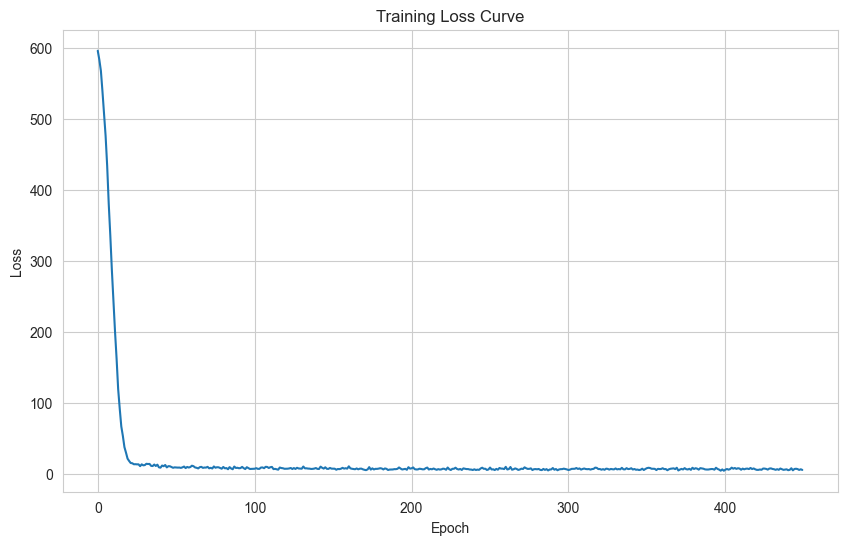


——————————————————————————————————————————————————
Model Evaluation Metrics:
MSE: 5.9493
RMSE: 2.4391
MAE: 1.8203
R² Score: 0.9047
——————————————————————————————————————————————————


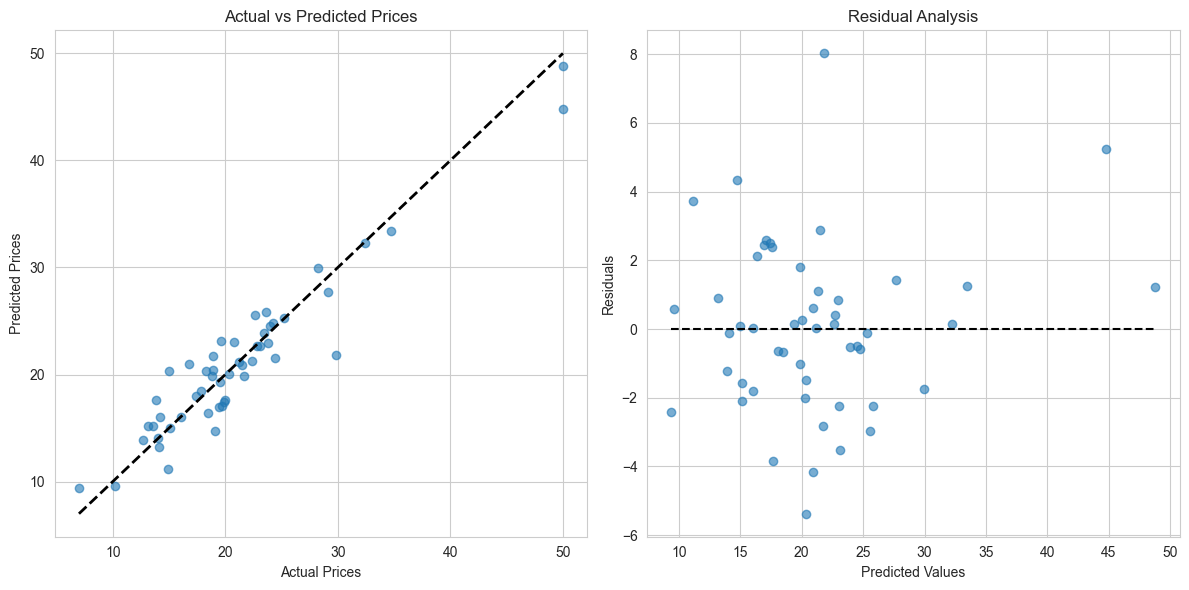

In [28]:
trained_model, loss_history = train_model(model, train_loader, epochs=450)
#绘制损失函数
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
    
evaluation_results = evaluate_model(trained_model, xt_test, yt_test)
    
# 保存模型
torch.save({
    'model_state_dict': trained_model.state_dict(), 'scaler': scaler, 'feature_names': feature_names, 'evaluation_metrics': evaluation_results 
}, "boston_housing_model.pth")